In [ ]:
# Add project root so we can import spine_score.src modules
# may need to rename spine-score folder to "spine_score"
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

# External libraries
import importlib
from pathlib import Path
import os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import amp
from tqdm import tqdm
import numpy as np

# Internal modules
from spine_score.src import extract, dataset, model
from spine_score.src.model import SimpleUNet3D

In [2]:
# Reloads modules (run for development update with the notebook)
importlib.reload(extract) 
importlib.reload(dataset)
importlib.reload(model)

<module 'spine_score.src.model' from 'C:\\Users\\Maxtw\\OneDrive\\Desktop\\Final Project 521\\aai-521-final-project\\spine_score\\src\\model.py'>

In [ ]:
class GeneralizedDiceFocalLoss3D(nn.Module):
    """
    Combines:
      - Focal Cross Entropy (class-balanced)
      - Generalized Dice (volume-balanced)

    logits:  [B, C, D, H, W]
    targets: [B, D, H, W]
    """
    def __init__(self, ce_weights, dice_weight=0.0, gamma=1.0, eps=1e-6):
        super().__init__()
        self.register_buffer("ce_weights", ce_weights.float())
        self.dice_weight = dice_weight
        self.gamma = gamma
        self.eps = eps

    # Focal Cross Entropy
    def focal_ce(self, logits, targets):
        log_probs = F.log_softmax(logits, dim=1)
        probs = torch.exp(log_probs)

        targets_flat = targets.long()
        pt = probs.gather(1, targets_flat.unsqueeze(1)).squeeze(1)
        log_pt = log_probs.gather(1, targets_flat.unsqueeze(1)).squeeze(1)

        focal_term = (1 - pt) ** self.gamma
        class_w = self.ce_weights[targets_flat]

        loss = -class_w * focal_term * log_pt
        return loss.mean()

    # Generalized Dice Loss
    def generalized_dice(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        num_classes = logits.shape[1]

        # One-hot encode
        target_1hot = F.one_hot(targets, num_classes=num_classes)
        target_1hot = target_1hot.permute(0, 4, 1, 2, 3).float()

        # Flatten spatial dims
        probs_f = probs.contiguous().view(logits.size(0), num_classes, -1)
        target_f = target_1hot.contiguous().view(logits.size(0), num_classes, -1)

        w = 1.0 / (target_f.sum(-1) ** 2 + self.eps)

        intersection = (probs_f * target_f).sum(-1)
        union = probs_f.sum(-1) + target_f.sum(-1)

        dice = (2 * intersection + self.eps) / (union + self.eps)
        gdice = 1.0 - (w * dice).sum() / w.sum()

        return gdice

    # Combined Loss
    def forward(self, logits, targets):
        ce = self.focal_ce(logits, targets)
        dice = self.generalized_dice(logits, targets)
        total = ce + self.dice_weight * dice
        return total, ce, dice

In [ ]:
def show_epoch_preview(images, masks, outputs, epoch, slice_mode="middle"):
    """
    Displays a single validation slice inline during training.
    Shows Original, Ground Truth, and Prediction.

    images:  [B,1,D,H,W]
    masks:   [B,D,H,W]
    outputs: [B,C,D,H,W]
    """
    cmap = ListedColormap(["black", "yellow", "red"])

    # pick first sample in batch
    vol = images[0,0].cpu()
    true_mask = masks[0].cpu()
    
    # Predicted labels
    probs = torch.softmax(outputs[0], dim=0)
    pred_mask = torch.argmax(probs, dim=0).cpu()

    # Slice selection
    if slice_mode == "middle":
        mid = vol.shape[-1] // 2
    else:
        fg_slices = torch.where(true_mask.sum(dim=(0,1)) > 0)[0]
        mid = int(fg_slices[len(fg_slices)//2]) if len(fg_slices) > 0 else vol.shape[-1]//2

    
    plt.figure(figsize=(14,5))
    plt.suptitle(f"Epoch {epoch+1} — Validation Preview", fontsize=14)

    # Original
    plt.subplot(1,3,1)
    plt.title("Original slice")
    plt.imshow(vol[:,:,mid], cmap="gray")
    plt.axis("off")

    # True Mask
    plt.subplot(1,3,2)
    plt.title("Ground truth mask")
    plt.imshow(vol[:,:,mid], cmap="gray")
    plt.imshow(true_mask[:,:,mid], cmap=cmap, alpha=0.6, vmin=0, vmax=2)
    plt.axis("off")

    # Prediction
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(vol[:,:,mid], cmap="gray")
    plt.imshow(pred_mask[:,:,mid], cmap=cmap, alpha=0.6, vmin=0, vmax=2)
    plt.axis("off")

    plt.show()

In [ ]:
def train_model(model, train_loader, val_loader, device,
                num_epochs=20, lr=5e-5, num_classes=3):

    model = model.to(device)

    # Optimizer & learning rate schedule
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=4, min_lr=1e-6
    )

    # Class weights for Focal CE
    # These weights currently make the model overpredict minority class (so we can still play around here)
    ce_weights = torch.tensor([0.1, 1.0, 2.0], device=device).float()

    criterion = GeneralizedDiceFocalLoss3D(
        ce_weights=ce_weights,
        dice_weight=0.0, # fixed for now
        gamma=1.0
    )

    scaler = amp.GradScaler()

    # History tracking
    best_dice = -1
    history = {
        "train_loss": [], "train_ce": [], "train_dice": [],
        "val_loss": [], "val_dice": [], "val_per_class": []
    }

    def dice_warmup(epoch):
        """Smooth warm-up 0 → 0.4 over 20 epochs"""
        return min(0.4, epoch / 20.0)

    # --- Training Loop ---
    for epoch in range(num_epochs):

        criterion.dice_weight = 0.0 # dice_warmup(epoch) is placed here
        # Fixed to zero because it seemed to make the model predict all one class eventually.

        model.train()
        train_loss = train_ce = train_dice = 0

        for images, masks, _ in tqdm(train_loader,
                                     desc=f"Epoch {epoch+1}/{num_epochs}",
                                     leave=False):
            images = images.to(device)
            masks = masks.squeeze(1).to(device)

            optimizer.zero_grad()

            with amp.autocast(device_type=device):
                outputs = model(images)
                loss, ce_val, dice_val = criterion(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            train_ce += ce_val.item()
            train_dice += dice_val.item()

        # Store training metrics
        n = len(train_loader)
        history["train_loss"].append(train_loss / n)
        history["train_ce"].append(train_ce / n)
        history["train_dice"].append(train_dice / n)

        # --------------------------
        # Validation Step
        # --------------------------
        model.eval()
        val_loss = 0
        dice_scores = []
        per_class_list = []

        with torch.no_grad():
            for images, masks, _ in val_loader:
                images = images.to(device)
                masks = masks.squeeze(1).to(device)

                outputs = model(images)
                loss, _, _ = criterion(outputs, masks)
                val_loss += loss.item()

                preds = outputs.argmax(1)

                # ----- per-class dice -------
                per_class = []
                for c in range(num_classes):
                    inter = ((preds == c) & (masks == c)).sum().item()
                    union = (preds == c).sum().item() + (masks == c).sum().item()
                    if union == 0:
                        per_class.append(1.0)
                    else:
                        per_class.append(2 * inter / union)
                per_class_list.append(per_class)

                dice_scores.append(np.mean(per_class))

        per_class_avg = np.mean(per_class_list, axis=0).tolist()

        # Inline Validation Preview
        model.eval()
        with torch.no_grad():
            val_images, val_masks, _ = next(iter(val_loader))
            val_images = val_images.to(device)
            val_masks = val_masks.squeeze(1).to(device)
            val_outputs = model(val_images)

        show_epoch_preview(val_images, val_masks, val_outputs, epoch)

        # Save Metrics
        history["val_loss"].append(val_loss / len(val_loader))
        history["val_dice"].append(np.mean(dice_scores))
        history["val_per_class"].append(per_class_avg)

        scheduler.step(history["val_dice"][-1])

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss={history['train_loss'][-1]:.4f} "
              f"CE={history['train_ce'][-1]:.4f} "
              f"DiceLoss={history['train_dice'][-1]:.4f} "
              f"ValDice={history['val_dice'][-1]:.4f} "
              f"(dice_w={criterion.dice_weight:.3f})")

        # Save best_model
        if history["val_dice"][-1] > best_dice:
            best_dice = history["val_dice"][-1]
            torch.save(model.state_dict(), "best_model.pth")
            print(f"🔥 Saved new best model (Dice={best_dice:.4f})")

    return model, history

In [ ]:
# Matching Study Ids to ensure that segmentation and images are mapped appropriately

# DICOM root after structural extraction
dicom_root = "../data/interim/imaging_files/case_image"

# Segmentation mask root
mask_root = "../data/interim/segmentation"

# Map study_id -> DICOM folder
dicom_map = {}
for folder in glob.glob(os.path.join(dicom_root, "*")):  # first level
    study_id = os.path.basename(folder)

    # pick the deepest folder containing DICOMs
    dcm_subfolders = [
        f for f in glob.glob(os.path.join(folder, "**"), recursive=True) 
        if os.path.isdir(f) and len(glob.glob(os.path.join(f, "*.dcm"))) > 0
    ]
    if dcm_subfolders:
        dicom_map[study_id] = dcm_subfolders[0]
        
# Map study_id -> segmentation file mapping
mask_map = {}
for mask_file in glob.glob(os.path.join(mask_root, "*_SEG.nii.gz")):
    study_id = os.path.basename(mask_file).split("_")[0]
    mask_map[study_id] = mask_file

# Only keep the studies that have both DICOMs and masks
dataset_entries = [(dicom_map[s], mask_map[s]) for s in dicom_map if s in mask_map]

print(f"Found {len(dataset_entries)} paired DICOMs and masks")
print(f"Example entry: {dataset_entries[0]}")

Found 1232 paired DICOMs and masks
Example entry: ('../data/interim/imaging_files/case_image\\593973-000001\\1.2.826.0.1.3680043.10.474.593973.2\\1.2.826.0.1.3680043.10.474.593973.3', '../data/interim/segmentation\\593973-000001_Study-MR-1_Series-22_SEG.nii.gz')


In [ ]:
from sklearn.model_selection import train_test_split

# dataset_entries already built earlier
print("Total samples:", len(dataset_entries))

# Split percentages: 70% train, 15% test, 15% val
train_entries, temp_entries = train_test_split(
    dataset_entries, test_size=0.3, random_state=42
)

val_entries, test_entries = train_test_split(
    temp_entries, test_size=0.5, random_state=42
)

print(f"Train 70%: {len(train_entries)}")
print(f"Val 15%:   {len(val_entries)}")
print(f"Test 15%:  {len(test_entries)}")


Total samples: 1232
Train 70%: 862
Val 15%:   185
Test 15%:  185


In [ ]:
# Create dataset + dataloaders
target_shape = (1, 224, 224, 48)  # divisible by 16 (if UNet has 4 downsamplings)
target_spacing=(1.0, 1.0, 1.0)

# Creating a dataset objects that knows how to load DICOM volumes + NIfTI masks one sample at a time
train_dataset = dataset.SpineSegDataset(train_entries, target_shape=target_shape, target_spacing=target_spacing)
val_dataset   = dataset.SpineSegDataset(val_entries, target_shape=target_shape, target_spacing=target_spacing)
test_dataset  = dataset.SpineSegDataset(test_entries, target_shape=target_shape, target_spacing=target_spacing)

# Wraps dataset into an iterable loader that handles batching + shuffling
# You may need to edit these values to efficiently train on your system (especially batch_size)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,
                          num_workers=8, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False,
                          num_workers=4, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_dataset,  batch_size=2, shuffle=False,
                          num_workers=4, pin_memory=True, persistent_workers=True)

Volume shape: torch.Size([2, 1, 224, 224, 48])
Mask shape: torch.Size([2, 224, 224, 48])


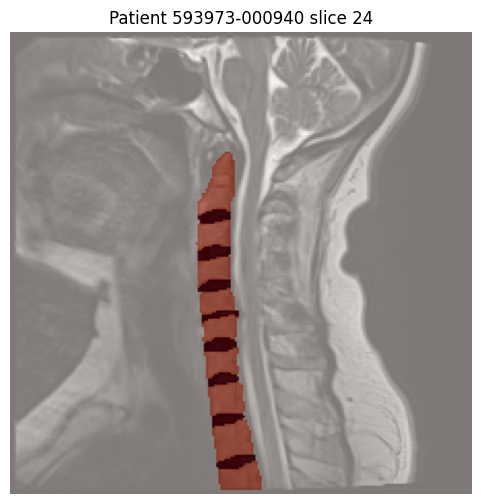

In [ ]:
# Preview one batch to ensure correct tensor shapes
vol, msk, patient_id = next(iter(train_loader))

print("Volume shape:", vol.shape)       # should be (batch, 1, H, W, D)
print("Mask shape:", msk.shape)         # should be (batch, H, W, D)

# Visualize a middle slice for the first patient in the batch
mid = msk.shape[-1] // 2
plt.figure(figsize=(6,6))
plt.imshow(vol[0,0,:,:,mid].cpu(), cmap="gray")
plt.imshow(msk[0,:,:,mid].cpu(), cmap="Reds", alpha=0.5)
plt.axis("off")
plt.title(f"Patient {patient_id[0]} slice {mid}")
plt.show()


Volume shape: torch.Size([2, 1, 224, 224, 48])
Mask shape:   torch.Size([2, 224, 224, 48])


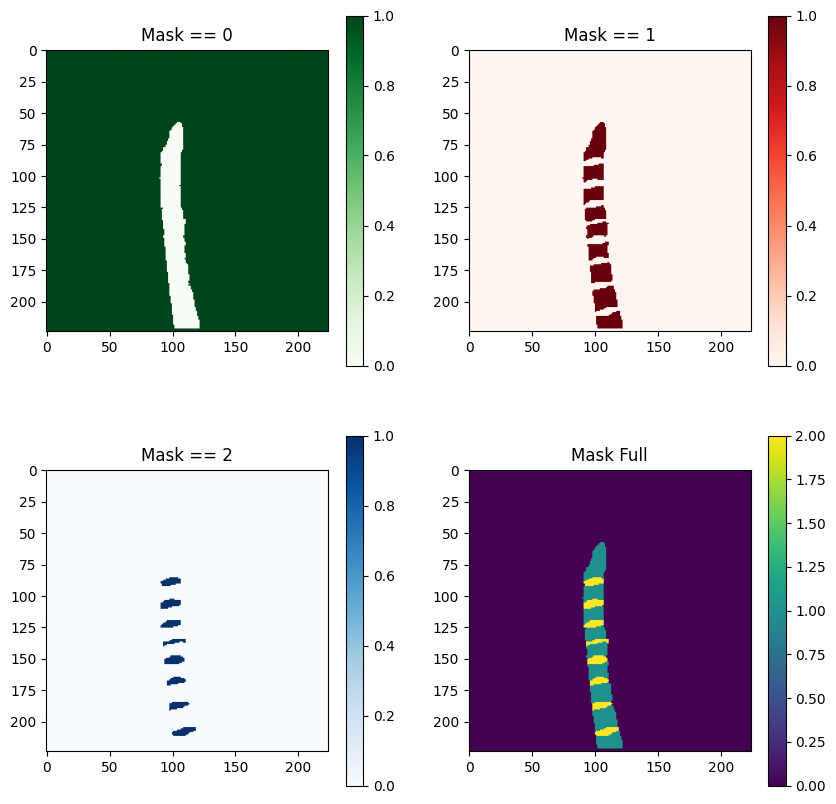

In [ ]:
# Inspect mask classes visually for the first sample

# vol, msk, patient_id = next(iter(train_loader)) # (obtained from previous cell)
print("Volume shape:", vol.shape)
print("Mask shape:  ", msk.shape)

# msk shape: (1, H, W, D)
mid = msk.shape[-1] // 2   # mid slice along depth

plt.figure(figsize=(10,10))

# Class 0
plt.subplot(2,2,1)
plt.title("Mask == 0")
plt.imshow((msk[0,:,:,mid] == 0).cpu(), cmap="Greens")
plt.colorbar()

# Class 1
plt.subplot(2,2,2)
plt.title("Mask == 1")
plt.imshow((msk[0,:,: ,mid] == 1).cpu(), cmap="Reds")
plt.colorbar()

# Class 2
plt.subplot(2,2,3)
plt.title("Mask == 2")
plt.imshow((msk[0,:,: ,mid] == 2).cpu(), cmap="Blues")
plt.colorbar()

# Complete mask
plt.subplot(2,2,4)
plt.title("Mask Full")
plt.imshow(msk[0,:,:,mid].cpu(), cmap="viridis")
plt.colorbar()

plt.show()


In [ ]:
# Print shapes from all splites to verify consistency

train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))
test_batch = next(iter(test_loader))

print(f"Train sample shapes: \nVolume: {train_batch[0].shape}, Mask: {train_batch[1].shape}")
print(f"Val sample shapes: \nVolume: {val_batch[0].shape}, Mask: {val_batch[1].shape}")
print(f"Test sample shapes: \nVolume: {test_batch[0].shape}, Mask: {test_batch[1].shape}")

# Unique labels in mask
print("Unique mask labels:", torch.unique(test_batch[1]))


Train sample shapes: 
Volume: torch.Size([2, 1, 224, 224, 48]), Mask: torch.Size([2, 224, 224, 48])
Val sample shapes: 
Volume: torch.Size([2, 1, 224, 224, 48]), Mask: torch.Size([2, 224, 224, 48])
Test sample shapes: 
Volume: torch.Size([2, 1, 224, 224, 48]), Mask: torch.Size([2, 224, 224, 48])
Unique mask labels: tensor([0, 1, 2])


cuda


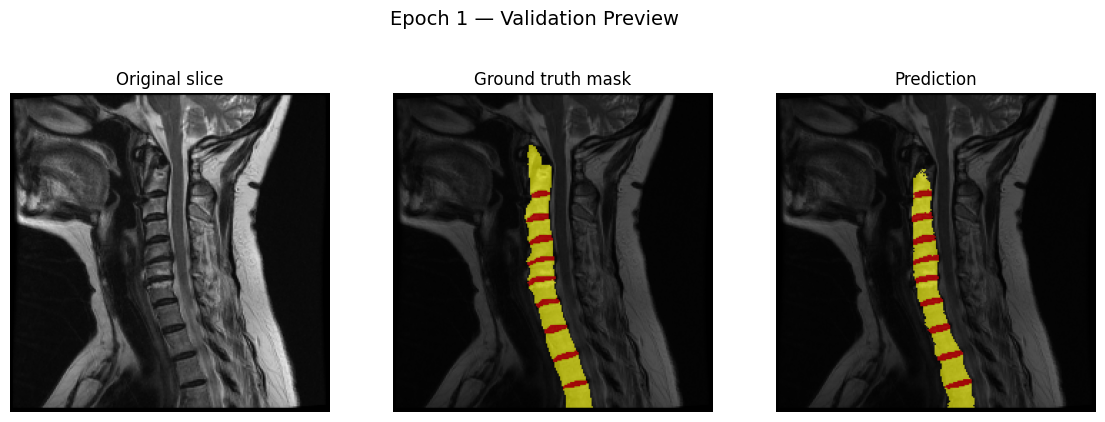

Epoch [1/3] Loss=0.0316 CE=0.0316 DiceLoss=0.9733 ValDice=0.8065 (dice_w=0.000)
🔥 Saved new best model (Dice=0.8065)


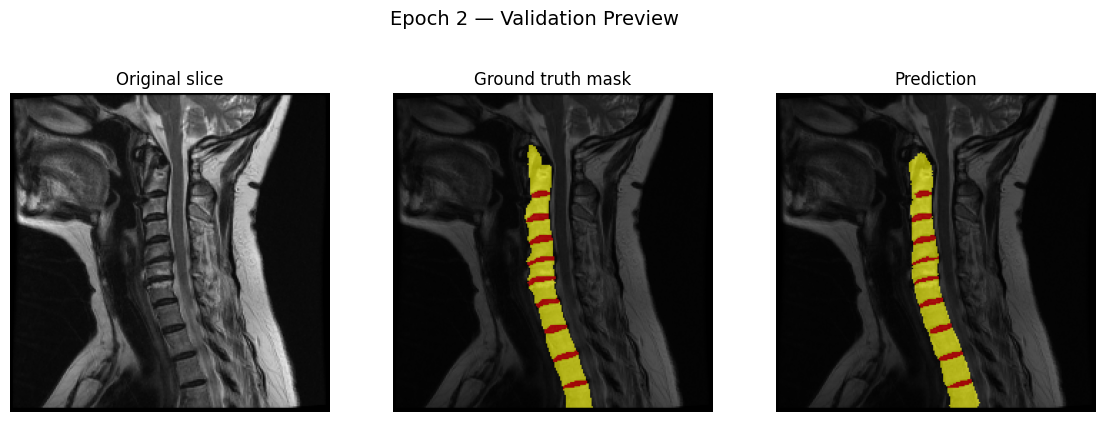

Epoch [2/3] Loss=0.0162 CE=0.0162 DiceLoss=0.9603 ValDice=0.8087 (dice_w=0.000)
🔥 Saved new best model (Dice=0.8087)


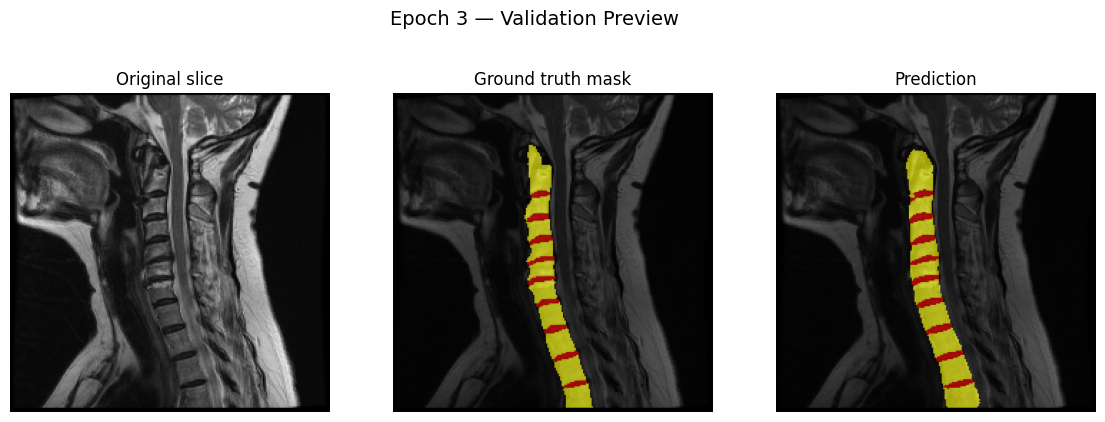

Epoch [3/3] Loss=0.0116 CE=0.0116 DiceLoss=0.9492 ValDice=0.8248 (dice_w=0.000)
🔥 Saved new best model (Dice=0.8248)


In [ ]:
# Set device + initialize model + train
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model_UNet = SimpleUNet3D(in_channels=1, out_channels=3)

model_UNet, history = train_model(
    model_UNet, 
    train_loader, 
    val_loader, 
    device, 
    num_epochs=3, 
    lr=5e-5, 
    num_classes=3
)

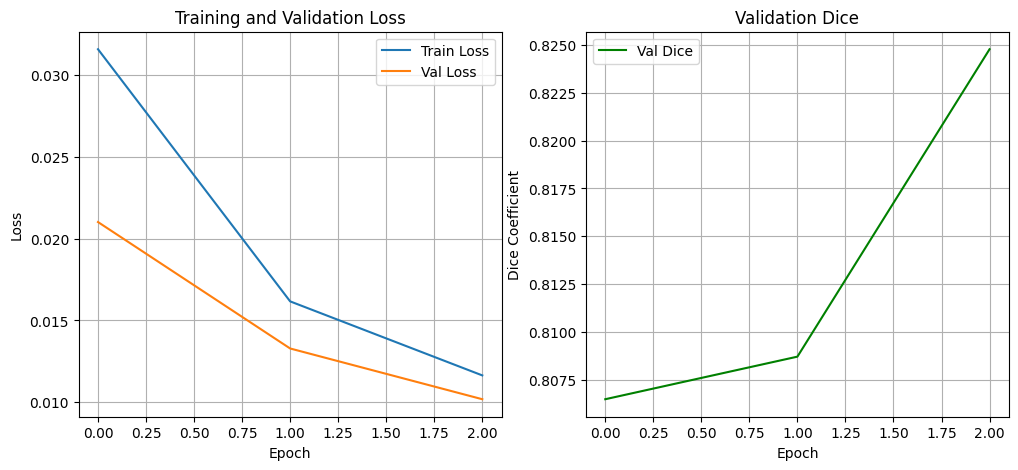

In [ ]:
# Plot Training Curves
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Dice
plt.subplot(1,2,2)
plt.plot(history['val_dice'], label='Val Dice', color='green')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Validation Dice')
plt.legend()
plt.grid(True)

plt.show()


In [22]:
# Save model weights
save_path = "../weights/unet3d_weights_v1.7.2.1.pth"
torch.save(model_UNet.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ../weights/unet3d_weights_v1.7.2.1.pth


Slices with foreground: tensor([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34])
Using slice: 26


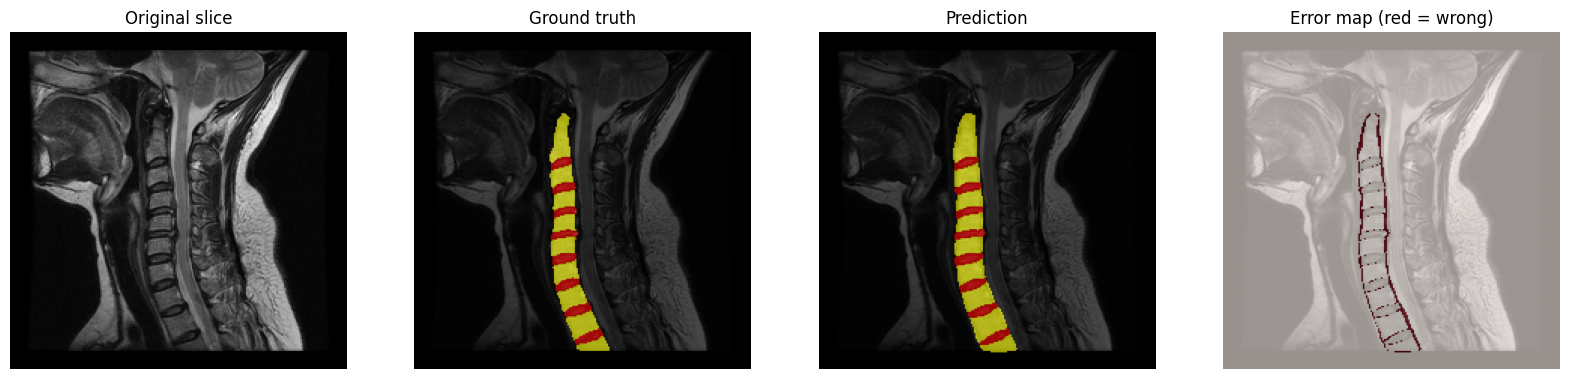

In [23]:
# Single-slice preview (Ground Truth vs Prediction vs Error)

model_UNet.load_state_dict(torch.load("../weights/unet3d_weights_v1.7.2.1.pth"))
model_UNet.eval()

cmap = ListedColormap(["black", "yellow", "red"])  # background, class1, class2

# Get one test batch
vol, msk, patient_id = next(iter(test_loader))
vol = vol.to(device)

with torch.no_grad():
    logits = model_UNet(vol)
    probs = torch.softmax(logits, dim=1)
    pred_labels = torch.argmax(probs, dim=1)

pred_mask = pred_labels[0].cpu()
true_mask = msk[0]
image = vol[0,0].cpu()

# Pick a foreground slice
slices_with_fg = torch.where(true_mask.sum(dim=(0,1)) > 0)[0]
print("Slices with foreground:", slices_with_fg[:20])
mid = int(slices_with_fg[len(slices_with_fg)//2])
print("Using slice:", mid)

# Error map
error_map = (pred_mask[:,:,mid] != true_mask[:,:,mid]).float()

# Plot
plt.figure(figsize=(20,6))

# Original slice
plt.subplot(1,4,1)
plt.title("Original slice")
plt.imshow(image[:,:,mid], cmap="gray")
plt.axis("off")

# Ground truth
plt.subplot(1,4,2)
plt.title("Ground truth")
plt.imshow(image[:,:,mid], cmap="gray")
plt.imshow(true_mask[:,:,mid], cmap=cmap, alpha=0.6, vmin=0, vmax=2)
plt.axis("off")

# Prediction
plt.subplot(1,4,3)
plt.title("Prediction")
plt.imshow(image[:,:,mid], cmap="gray")
plt.imshow(pred_mask[:,:,mid], cmap=cmap, alpha=0.6, vmin=0, vmax=2)
plt.axis("off")

# Error
plt.subplot(1,4,4)
plt.title("Error map (red = wrong)")
plt.imshow(image[:,:,mid], cmap="gray")
plt.imshow(error_map, cmap="Reds", alpha=0.6)
plt.axis("off")

plt.show()


Saved GIF: ../gifs/volume_slices1.gif


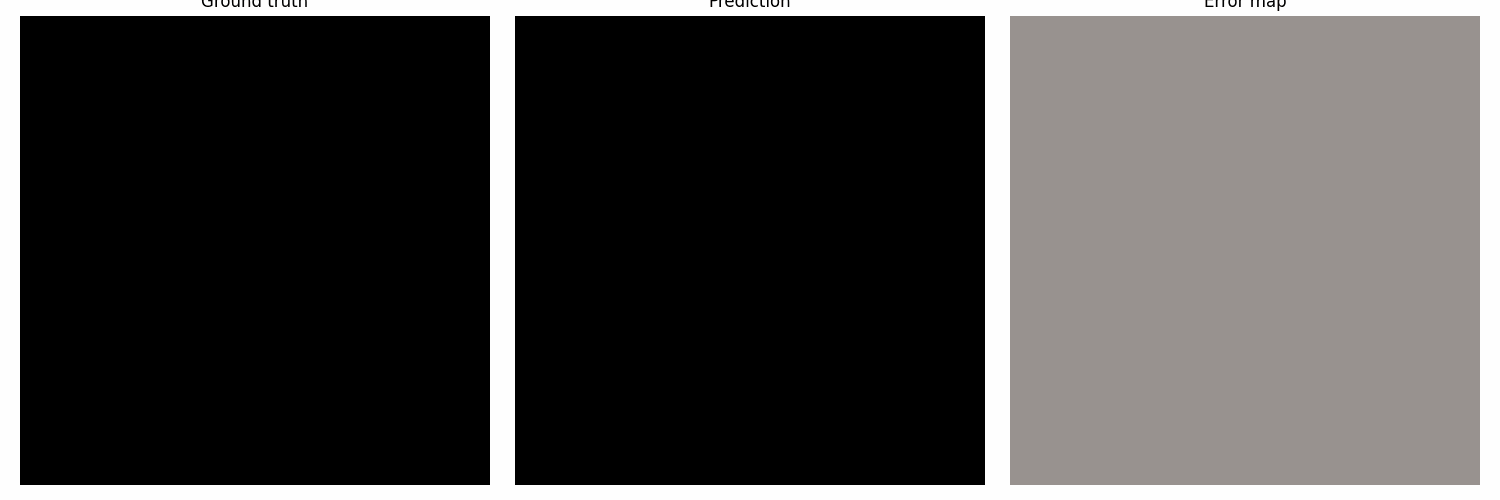

In [24]:
# Generate GIF: Ground Truth v Prediction vs Error (full volume)
import imageio
from io import BytesIO
from IPython.display import Image, display

model_UNet.load_state_dict(torch.load("../weights/unet3d_weights_v1.7.2.1.pth"))
model_UNet.eval()

cmap = ListedColormap(["black", "yellow", "red"])

vol, msk, patient_id = next(iter(test_loader))
vol = vol.to(device)

with torch.no_grad():
    logits = model_UNet(vol)
    probs = torch.softmax(logits, dim=1)
    pred_labels = torch.argmax(probs, dim=1)

pred_mask = pred_labels[0].cpu()
true_mask = msk[0]
image = vol[0,0].cpu()

# Error map volume
error_map_vol = (pred_mask != true_mask).float()

frames = []

# Generate frames slice by slice
for s in range(image.shape[2]):
    fig, axes = plt.subplots(1, 3, figsize=(15,5))

    # Ground truth
    axes[0].imshow(image[:,:,s], cmap="gray")
    axes[0].imshow(true_mask[:,:,s], cmap=cmap, alpha=0.6, vmin=0, vmax=2)
    axes[0].set_title("Ground truth")
    axes[0].axis("off")

    # Prediction
    axes[1].imshow(image[:,:,s], cmap="gray")
    axes[1].imshow(pred_mask[:,:,s], cmap=cmap, alpha=0.6, vmin=0, vmax=2)
    axes[1].set_title("Prediction")
    axes[1].axis("off")

    # Error
    axes[2].imshow(image[:,:,s], cmap="gray")
    axes[2].imshow(error_map_vol[:,:,s], cmap="Reds", alpha=0.6)
    axes[2].set_title("Error map")
    axes[2].axis("off")

    plt.tight_layout()

    # Save current frame
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    frames.append(imageio.v2.imread(buf))

# Save GIF
gif_path = "../gifs/volume_slices1.gif"
imageio.mimsave(gif_path, frames, fps=5, loop=0)
print(f"Saved GIF: {gif_path}")

# Display inline
display(Image(filename=gif_path))


In [25]:
# Predicted vs True Class Frequencies
pred_unique, pred_counts = torch.unique(pred_labels.cpu(), return_counts=True)
true_unique, true_counts = torch.unique(true_mask.cpu(), return_counts=True)

print("PRED classes:", pred_unique, pred_counts)
print("TRUE classes:", true_unique, true_counts)


PRED classes: tensor([0, 1, 2]) tensor([4702323,   88685,   25888])
TRUE classes: tensor([0, 1, 2]) tensor([2370168,   28163,   10117])


The above matches up with what I said before, the minority class is being overpredicted.  
We can mess with the weights as well as dice warm-up a bit more before this model is perfect.